In [1]:
import pandas as pd
import numpy as np

import utils.print as print_f

from utils.coco_eval import get_eval_params_dict
from utils.engine import xami_train_one_epoch, xami_evaluate
from utils.plot import plot_loss, plot_train_val_evaluators, plot_evaluator
from utils.save import get_train_data
from datetime import datetime

from utils.save import check_best, end_train
from data.load import get_datasets, get_dataloaders
from models.load import get_trained_model

from IPython.display import clear_output
from utils.eval import get_ar_ap
from utils.train import get_optimiser
from utils.init import reproducibility, clean_memory_get_device
from utils.constants import full_iou_thrs
from data.constants import DEFAULT_REFLACX_LABEL_COLS, XAMI_MIMIC_PATH


## Suppress the assignement warning from pandas.r
pd.options.mode.chained_assignment = None  # default='warn'

## Supress user warning
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

%matplotlib inline

In [2]:
# Define the trained models here:
from enum import Enum

class TrainedModels(Enum):
    
    pretrained_resnet50_without_clinical_ap = "val_ar_0_5272_ap_0_2396_test_ar_0_6170_ap_0_1962_epoch44_WithoutClincal_04-19-2022 07-35-55_pretrained_resnet50_without_clinical"
    pretrained_resnet50_without_clinical_ar = "val_ar_0_5272_ap_0_2396_test_ar_0_6170_ap_0_1962_epoch44_WithoutClincal_04-19-2022 07-35-46_pretrained_resnet50_without_clinical"
    pretrained_resnet50_without_clinical_final = "val_ar_0_3257_ap_0_1868_test_ar_0_4210_ap_0_1598_epoch100_WithoutClincal_04-19-2022 12-44-29_pretrained_resnet50_without_clinical"
    pretrained_resnet50_with_clinical_ap = "val_ar_0_4246_ap_0_2378_test_ar_0_4963_ap_0_1712_epoch98_WithClincal_04-19-2022 22-54-16_pretrained_resnet50_with_clinical"
    pretrained_resnet50_with_clinical_ar = "val_ar_0_5164_ap_0_1869_test_ar_0_5086_ap_0_1718_epoch64_WithClincal_04-19-2022 19-33-35_pretrained_resnet50_with_clinical"
    pretrained_resnet50_with_clinical_final = "val_ar_0_3271_ap_0_1848_test_ar_0_3900_ap_0_1726_epoch100_WithClincal_04-19-2022 23-06-47_pretrained_resnet50_with_clinical"
    custom_with_clinical_no_pretrained_ar = "val_ar_0_5220_ap_0_2513_test_ar_0_5590_ap_0_2442_epoch150_WithClincal_04-13-2022 20-13-47_custom_with_clinical_no_pretrained"
    custom_with_clinical_no_pretrained_ap = "val_ar_0_4554_ap_0_2582_test_ar_0_5254_ap_0_2405_epoch139_WithClincal_04-13-2022 19-05-08_custom_with_clinical_no_pretrained"
    custom_with_clinical_no_pretrained_final = "val_ar_0_4523_ap_0_2251_test_ar_0_5103_ap_0_2464_epoch200_WithClincal_04-14-2022 01-32-28_custom_with_clinical_no_pretrained"
    custom_without_clinical_no_pretrained_ar = "val_ar_0_5645_ap_0_2659_test_ar_0_6263_ap_0_2533_epoch145_WithoutClincal_04-13-2022 08-47-34_custom_without_clinical_no_pretrained"
    custom_without_clinical_no_pretrained_ap = "val_ar_0_5512_ap_0_2962_test_ar_0_5999_ap_0_2319_epoch93_WithoutClincal_04-12-2022 09-15-28_custom_without_clinical_no_pretrained"
    custom_without_clinical_no_pretrained_final = "val_ar_0_3757_ap_0_1699_test_ar_0_4421_ap_0_1819_epoch200_WithoutClincal_04-13-2022 14-58-52_custom_without_clinical_no_pretrained"
    custom_without_clinical_swim_ap = "val_ar_0_5307_ap_0_2054_test_ar_0_5321_ap_0_1726_epoch87_WithoutClincal_04-17-2022 06-51-10_custom_without_clinical_swim"
    custom_without_clinical_swim_ar = "val_ar_0_5313_ap_0_1540_test_ar_0_5906_ap_0_1486_epoch59_WithoutClincal_04-17-2022 05-48-30_custom_without_clinical_swim"
    custom_without_clinical_swim_final = "val_ar_0_2175_ap_0_1390_test_ar_0_2231_ap_0_0901_epoch200_WithoutClincal_04-17-2022 10-49-59_custom_without_clinical_swim"
    custom_with_clinical_swim_ap = "val_ar_0_5081_ap_0_2210_test_ar_0_5392_ap_0_1725_epoch95_WithClincal_04-17-2022 15-26-02_custom_with_clinical_swim"
    custom_with_clinical_swim_ar = "val_ar_0_5377_ap_0_1821_test_ar_0_4561_ap_0_1193_epoch67_WithClincal_04-17-2022 14-02-28_custom_with_clinical_swim"
    custom_with_clinical_swim_final = "val_ar_0_2752_ap_0_1293_test_ar_0_3391_ap_0_1097_epoch200_WithClincal_04-17-2022 20-31-24_custom_with_clinical_swim"



In [3]:
device = clean_memory_get_device()
reproducibility()

This notebook will running on device: [CUDA]


In [4]:
get_epoch_from_model = lambda select_model: int(([substr for substr in select_model.value.split("_") if "epoch" in substr][0]).replace("epoch", ""))
get_model_name = lambda select_model: str(select_model).split(".")[-1]

In [5]:
iou_thrs = np.array([0.5])
use_iobb = True

train_more_models = [
    # TrainedModels.custom_without_clinical_no_pretrained_final,
    TrainedModels.pretrained_resnet50_without_clinical_final,
    TrainedModels.pretrained_resnet50_with_clinical_final,

]

labels_cols = DEFAULT_REFLACX_LABEL_COLS

target_epoch = 200

# need to create a list for storing the namimg.
train_infos = []

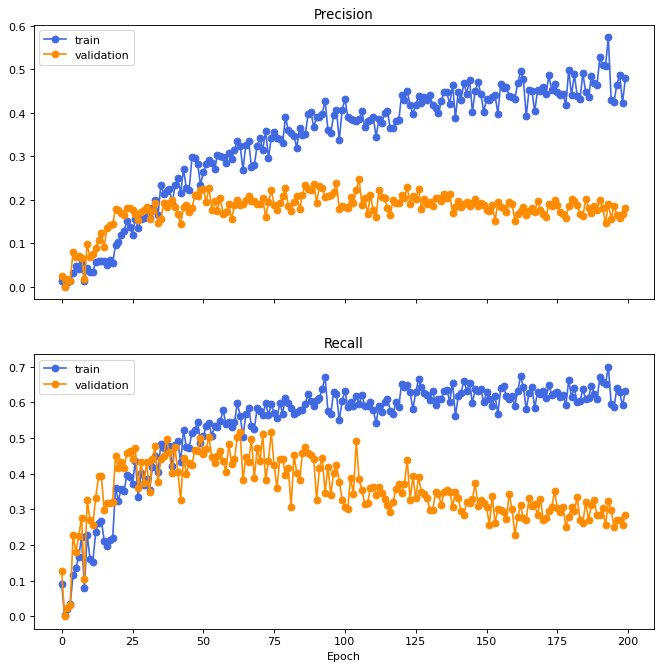

====================| Epoch [200] Done | It has took [572.32] min, Avg time: [343.39] sec/epoch | Estimate time for [100] epochs: [572.32] min |====================
====================| Training Done, start testing! | [200] Epochs Training time: [55318] seconds, Avg time / Epoch: [276.59] seconds====================
====================Best AP validation model has been saved to: [val_ar_0_3842_ap_0_2467_test_ar_0_3799_ap_0_1727_epoch106_WithClincal_04-20-2022 19-09-13_pretrained_resnet50_with_clinical]====================
====================Best AR validation model has been saved to: [val_ar_0_5164_ap_0_1869_test_ar_0_5086_ap_0_1718_epoch64_WithClincal_04-19-2022 19-33-35_pretrained_resnet50_with_clinical]====================
creating index...
index created!
Test:  [ 0/23]  eta: 0:00:23  model_time: 0.2468 (0.2468)  evaluator_time: 0.0230 (0.0230)  time: 1.0270  data: 0.5181  max mem: 3542
Test:  [22/23]  eta: 0:00:00  model_time: 0.1870 (0.1961)  evaluator_time: 0.1920 (0.2141)  tim

In [6]:
for select_model in train_more_models:

    # load the model.
    model, train_info, optimizer = get_trained_model(
        select_model,
        labels_cols,
        device,
        image_size=512,
        rpn_nms_thresh=0.3,
        box_detections_per_img=10,
        box_nms_thresh=0.2,
        rpn_score_thresh=0.0,
        box_score_thresh=0.05,
    )
    model.train()

    model_setup = train_info.model_setup

    # build the dataset again.
    dataset_params_dict = {
        "XAMI_MIMIC_PATH": XAMI_MIMIC_PATH,
        "with_clinical": model_setup.use_clinical,
        "dataset_mode": model_setup.dataset_mode,
        "bbox_to_mask": True,
        "labels_cols": labels_cols,
    }

    detect_eval_dataset, train_dataset, val_dataset, test_dataset = get_datasets(
        dataset_params_dict=dataset_params_dict
    )

    train_dataloader, val_dataloader, test_dataloader = get_dataloaders(
        train_dataset, val_dataset, test_dataset, batch_size=4
    )

    if not optimizer:
        optimizer = get_optimiser(model, model_setup,)

    lr_scheduler = None

    eval_params_dict = get_eval_params_dict(
        detect_eval_dataset, iou_thrs=iou_thrs, use_iobb=use_iobb,
    )

    # get current epoch.
    last_trainng_epoch = train_info.epoch

    num_epochs_to_run = target_epoch - last_trainng_epoch

    start_t = datetime.now()

    for e in range(last_trainng_epoch, target_epoch):

        print_f.print_title(f"Training model: [{model_setup.name}]")

        train_info.epoch = e + 1

        ###### Perform training and show the training result here ######
        model.train()

        train_loger = xami_train_one_epoch(
            model, optimizer, train_dataloader, device, train_info.epoch, print_freq=10,
        )

        train_info.train_data.append(get_train_data(train_loger))

        plot_loss(train_info.train_data)
        ################################################################

        ### update the learning rate
        if not lr_scheduler is None:
            lr_scheduler.step()

        ####### Put the model into evaluation mode, start evaluating the current model #######
        model.eval()

        if model_setup.record_training_performance:
            ### evaluate on the validation dataset
            train_evaluator = xami_evaluate(
                model, train_dataloader, device=device, params_dict=eval_params_dict
            )
            train_info.train_evaluators.append(train_evaluator)

        val_evaluator = xami_evaluate(
            model, val_dataloader, device=device, params_dict=eval_params_dict
        )

        train_info.val_evaluators.append(val_evaluator)

        ## Clean everything before we show the evaluating result in this stage, so we can inspect the training progress.
        clear_output()

        if model_setup.record_training_performance:
            plot_train_val_evaluators(
                train_info.train_evaluators,
                train_info.val_evaluators,
                areaRng="all",
                iouThr=0.5,
                maxDets=10,
            )
        else:
            plot_evaluator(
                train_info.val_evaluators, iouThr=0.5, areaRng="all", maxDets=10,
            )

        current_time = datetime.now()
        sec_took = (current_time - start_t).seconds
        speed = sec_took / (train_info.epoch - last_trainng_epoch)

        print_f.print_title(
            f"| Epoch [{train_info.epoch}] Done | It has took [{sec_took/60:.2f}] min, Avg time: [{speed:.2f}] sec/epoch | Estimate time for [{num_epochs_to_run}] epochs: [{speed*num_epochs_to_run/60:.2f}] min |"
        )

        #######################################################################################
        if model_setup.use_early_stop_model:
            val_ar, val_ap, train_info = check_best(
                device=device,
                eval_params_dict=eval_params_dict,
                train_info=train_info,
                model=model,
                optim=optimizer,
                test_dataloader=test_dataloader,
            )

    val_ar, val_ap = get_ar_ap(train_info.val_evaluators[-1])

    train_info = end_train(
            train_info=train_info,
            model=model,
            optim=optimizer,
            eval_params_dict=eval_params_dict,
            last_val_ar=val_ar,
            last_val_ap=val_ap,
            test_dataloader=test_dataloader,
            device=device,
    )

    train_infos.append(train_info)


In [7]:
for train_info in train_infos:
    print(train_info)

========================================For Training [pretrained_resnet50_without_clinical]========================================
ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='pretrained_resnet50_without_clinical', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=True, record_training_performance=True, dataset_mode='unified')

Best AP validation model has been saved to: [val_ar_0_5272_ap_0_2396_test_ar_0_6170_ap_0_1962_epoch44_WithoutClincal_04-19-2022 07-35-55_pretrained_resnet50_without_clinical]
Best AR validation model has been saved to: [val_ar_0_5272_ap_0_2396_test_ar_0_6170_ap_0_1962_epoch44_WithoutClincal_04-19-2022 07-35-46_pretrained_resnet50_without_clinical]
The final model has been saved to: [val_ar_0_2560_ap_0_1522_test_ar_0_3072_ap_0_1295_epoch200_WithoutClincal_04-20-2022 18-32-16_pretrained_resnet50_without_clinical]

In [8]:
# ========================================For Training [custom_with_clinical_no_pretrained]========================================
# ModelSetup(use_clinical=True, use_custom_model=True, use_early_stop_model=True, name='custom_with_clinical_no_pretrained', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=False, record_training_performance=True, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5220_ap_0_2513_test_ar_0_5590_ap_0_2442_epoch150_WithClincal_04-13-2022 20-13-47_custom_with_clinical_no_pretrained]
# Best AP validation model has been saved to: [val_ar_0_4554_ap_0_2582_test_ar_0_5254_ap_0_2405_epoch139_WithClincal_04-13-2022 19-05-08_custom_with_clinical_no_pretrained]
# The final model has been saved to: [val_ar_0_4523_ap_0_2251_test_ar_0_5103_ap_0_2464_epoch200_WithClincal_04-14-2022 01-32-28_custom_with_clinical_no_pretrained]

# ========================================For Training [custom_without_clinical_no_pretrained]========================================
# ModelSetup(use_clinical=False, use_custom_model=True, use_early_stop_model=True, name='custom_without_clinical_no_pretrained', best_ar_val_model_path=None, best_ap_val_model_path=None, final_model_path=None, backbone='resnet50', optimiser='sgd', lr=0.0005, weight_decay=5e-05, pretrained=False, record_training_performance=True, dataset_mode='unified')
# ========================================
# Best AR validation model has been saved to: [val_ar_0_5645_ap_0_2659_test_ar_0_6263_ap_0_2533_epoch145_WithoutClincal_04-13-2022 08-47-34_custom_without_clinical_no_pretrained]
# Best AP validation model has been saved to: [val_ar_0_5512_ap_0_2962_test_ar_0_5999_ap_0_2319_epoch93_WithoutClincal_04-12-2022 09-15-28_custom_without_clinical_no_pretrained]
# The final model has been saved to: [val_ar_0_3757_ap_0_1699_test_ar_0_4421_ap_0_1819_epoch200_WithoutClincal_04-13-2022 14-58-52_custom_without_clinical_no_pretrained]